In [210]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nltk

In [270]:
df = pd.read_csv("Data_totaldata.csv")
df_train = pd.read_csv("Data_train.csv")
df_test = pd.read_csv("Data_test.csv")
df_val = pd.read_csv("Data_val.csv")

In [271]:
drop_indices = []
for i in df.index:
    if '#AUTHOR_TAG' not in df['citation_context'].loc[i]:
        if df['unique_id'].loc[i] in list(df_train['unique_id']):
            row = np.where(df_train['unique_id'] == df['unique_id'].loc[i])
            df_train = df_train.drop(index = [row[0][0]])
        elif df['unique_id'].loc[i] in list(df_test['unique_id']):
            row = np.where(df_test['unique_id'] == df['unique_id'].loc[i])
            df_test = df_test.drop(index = [row[0][0]])
        else:
            row = np.where(df_val['unique_id'] == df['unique_id'].loc[i])
            df_val = df_val.drop(index = [row[0][0]])
        drop_indices.append(i)

df = df.drop(index = drop_indices)

In [272]:
print(len(df_train), len(df_test), len(df_val), len(df))

2525 231 241 2997


# Keyword Overlap

In [343]:
# First get the dataframe of just the citing and cited tited as well as teh class label
title_df = df[["citing_title", "cited_title", "citation_class_label", "citation_influence_label"]]
title_df.head()

citing_title  \
0  Ontology-Based Recommendation of Editorial Pro...   
1  Ontology-Based Recommendation of Editorial Pro...   
2  Ontology-Based Recommendation of Editorial Pro...   
3  Ontology-Based Recommendation of Editorial Pro...   
4  Ontology-Based Recommendation of Editorial Pro...   

                                         cited_title  citation_class_label  \
0  Web search personalization with ontological us...                     5   
1             Exploring Scholarly Data with Rexplore                     0   
2  Klink-2: Integrating Multiple Web Sources to G...                     0   
3  Forecasting the Spreading of Technologies in R...                     0   
4  Supporting Springer Nature Editors by means of...                     5   

   citation_influence_label  
0                         0  
1                         0  
2                         0  
3                         1  
4                         1

In [276]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 

def drop_stop_words(title):
    """Drop the core english stopwords in a title. Additionally stem and lemmatize them as well."""
    
    # Break apart hyphenated words
    hyphen_split = title.split('-')
    title = " ".join(hyphen_split)
    
    # First tokenize the input to break it into parts
    word_tokens = word_tokenize(title)
    
    # Get the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter and reconstruct. Also stem the words
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if not w in stop_words]  
  
    return filtered_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\binyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\binyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [277]:
# Create a new column in the dataframe to store the overlap feature
title_df["keyword_overlap"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citing and cited title
    citing_title = title_df.loc[row]["citing_title"]
    cited_title = title_df.loc[row]["cited_title"]
    
    # Compute the filtered versions of both
    citing_words = drop_stop_words(citing_title)
    cited_words = drop_stop_words(cited_title)
    
    # Count the overlap
    overlap = len(set(citing_words) & set(cited_words)) 
    title_df.at[row,"keyword_overlap"] = overlap

C:\Users\binyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Number of verbs + Verb Tense

In [278]:
def count_verbs(context):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if "VB" in tag[1]:
            verb_count += 1
    
    return verb_count

In [279]:
# Create a new column in the dataframe to store the num verbs feature
df["num_verbs"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citation context
    context = df.loc[row]["citation_context"]
    
    # Compute the verb count
    verb_count = count_verbs(context)
    
    # Count the overlap
    df.at[row,"num_verbs"] = verb_count

In [280]:
def count_verbs_tense(context, tense):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if tense in tag[1]:
            verb_count += 1
    
    return verb_count

In [281]:
tenses = ["VB","VBZ", "VBG", "VBN", "VBD"]
for tense in tenses:
    # Create feature
    feature_name = f"num_verbs_{tense}"
    df[feature_name] = np.zeros(df.shape[0])

    # Traverse through all the rows of the dataframe and generate the new feature
    for row in df.index:
        # Grab the citation context
        context = df.loc[row]["citation_context"]

        # Compute the verb count
        verb_count = count_verbs_tense(context, tense)

        # Count the overlap
        df.at[row,feature_name] = verb_count

# Structural features

In [282]:
df['citation_rel_loc'] = (df['citation_context'].str.index("#AUTHOR_TAG")) / (df['citation_context'].str.len() - 11)

In [283]:
citation_rel_punc = []
for i in df.index:
    text = df['citation_context'].loc[i]
    ind = text.index('#AUTHOR_TAG')
    val = -1
    start = 0
    end = len(text) - 1
    for j in range(ind, 0, -1):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            start = j
            break
    for j in range(ind, len(text)):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            end = j
            break
    end -= 10
    val = (ind - start) / (end - start)
    citation_rel_punc.append(val)

df['citation_rel_punc'] = citation_rel_punc

In [284]:
df['citation_len'] = df['citation_context'].str.split().str.len() - 1 # -1 for #AUTHOR_TAG

In [285]:
df['num_citations'] = df['citation_context'].str.count('\[') - df['citation_context'].str.count('\[#AUTHOR_TAG\]')

In [286]:
citation_in_paren = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ')':
            for k in range(j, 0, -1):
                if text[k] == '(':
                    if ind > k and ind < j:
                        flag = 1
    citation_in_paren.append(flag)

df['citation_in_paren'] = citation_in_paren

In [287]:
active_verb = []
for i in range(len(df)):
    text = nltk.word_tokenize(df['citation_context'].iloc[i])
    pos_tagged = nltk.pos_tag(text)
    for s in [y[0] for y in pos_tagged]:
        if 'AUTHOR_TAG' in s:
            index = [y[0] for y in pos_tagged].index(s)
            break
    if index != len(pos_tagged) - 1 and 'VB' in pos_tagged[index + 1][1]:
        active_verb.append(1)
    else:
        active_verb.append(0)
        
df['active_verb'] = active_verb

In [288]:
desc = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ',':
            if j + 2 < len(text) and text[j + 2] == 'a':
                flag = 1
            break
    desc.append(flag)

df['citation_description'] = desc

# Sentence Pattern

In [289]:
from getSentencePattern import get_custom_pattern_features_wrapper, countCases

sent_pat_feature = df['citation_context'].apply(get_custom_pattern_features_wrapper)

In [290]:
types = ['Background', 'CompareOrContrast', 'Prior', 'Future', 'Motivation', 'Uses']

for i in range(len(types)):
    # Convert each feature into a number (count the cases)
    score = sent_pat_feature.apply(countCases, args=(types[i], ))
    feature_name = f"sentence_pattern_{types[i]}"
    df[feature_name] = score

# Stop Word Embedding

In [291]:
df["tokens"] = [word_tokenize(context.replace("#AUTHOR_TAG", "")) for context in df["citation_context"]]


threshold = 3 #frequency threshold for throwing out words

tokenized_corpus = []
[tokenized_corpus.extend(word_tokenize(context.replace("#AUTHOR_TAG", ""))) for context in df["citation_context"]]
fdist = nltk.FreqDist(tokenized_corpus)
fdftotal = pd.DataFrame(fdist.items(), columns = ['word', 'freq'])
fdf = fdftotal.loc[fdftotal.freq > threshold]

In [292]:
glovepath = "./glove.6B"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [293]:
#Generate embeddings out of tokenized sentences
def embed_context(tokens, fdf):
    vector = []
    for word in tokens:
        if word in fdf["word"].values and word in embeddings_dict:
            vector.append(embeddings_dict[word])
    return np.sum(vector, axis=0)

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])

In [294]:
temp = []
for i in range(len(X)):
    t = tuple(X[i])
    temp.append(t)

# Concatenate features

In [295]:
df['embedding'] = list(zip(title_df.keyword_overlap, df.num_verbs, df.num_verbs_VB, df.num_verbs_VBD, 
                           df.num_verbs_VBN, df.num_verbs_VBG, df.num_verbs_VBZ, df.citation_rel_loc,
                           df.citation_rel_punc, df.citation_len, df.num_citations, df.citation_in_paren,
                           df.active_verb, df.citation_description, df.sentence_pattern_Background,
                           df.sentence_pattern_CompareOrContrast, df.sentence_pattern_Motivation, df.sentence_pattern_Uses,
                           df.sentence_pattern_Prior))
#  df.sentence_pattern_Future are all array of 0's.
embed = []
for i in range(len(df)):
    t = df['embedding'].iloc[i] + temp[i]
    embed.append(t)
    
# Normalize features
temp1 = pd.DataFrame(np.array(embed))
for c in temp1.columns:
    if temp1[c].max() == temp1[c].min():
        print(c)
    temp1[c] = (temp1[c] - temp1[c].min()) / (temp1[c].max() - temp1[c].min())

e1 = list(map(tuple, np.array(temp1)))

df['embedding'] = e1

In [296]:
df['embedding'].head()

0    (0.0, 0.09523809523809523, 0.09523809523809523...
1    (0.0, 0.2857142857142857, 0.2857142857142857, ...
2    (0.0, 0.23809523809523808, 0.23809523809523808...
3    (0.0, 0.38095238095238093, 0.38095238095238093...
4    (0.0, 0.3333333333333333, 0.3333333333333333, ...
Name: embedding, dtype: object

# Get training + test set

In [303]:
train_embed = []
test_embed = []
val_embed = []

for i in df.index:
    if df['unique_id'].loc[i] in list(df_train['unique_id']):
        train_embed.append(df['embedding'].loc[i])
        # row = np.where(df_train['unique_id'] == df['unique_id'].loc[i])
        # df_train.at[row[0][0], 'embedding'] = df['embedding'].loc[i]
    elif df['unique_id'].loc[i] in list(df_test['unique_id']):
        test_embed.append(df['embedding'].loc[i])
        # row = np.where(df_test['unique_id'] == df['unique_id'].loc[i])
        # df_test.at[row[0][0], 'embedding'] = df['embedding'].loc[i] 
    elif df['unique_id'].loc[i] in list(df_val['unique_id']):
        val_embed.append(df['embedding'].loc[i])
    else:
        train_embed.append(df['embedding'].loc[i])

In [304]:
print(len(train_embed), len(test_embed), len(val_embed))

2525 231 241


In [300]:
print(len(df_train), len(df_test), len(df_val), len(df))

2525 231 241 2997


In [305]:
df_train['embedding'] = train_embed
df_test['embedding'] = test_embed
df_val['embedding'] = val_embed

In [313]:
trainX = np.array([*df_train['embedding']])
testX = np.array([*df_test['embedding']])

# Train basic models

## Logistic Regression

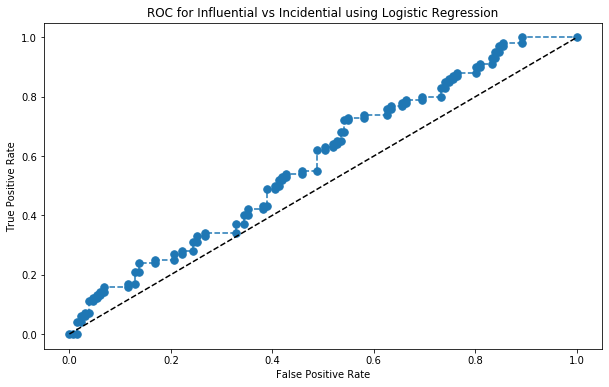

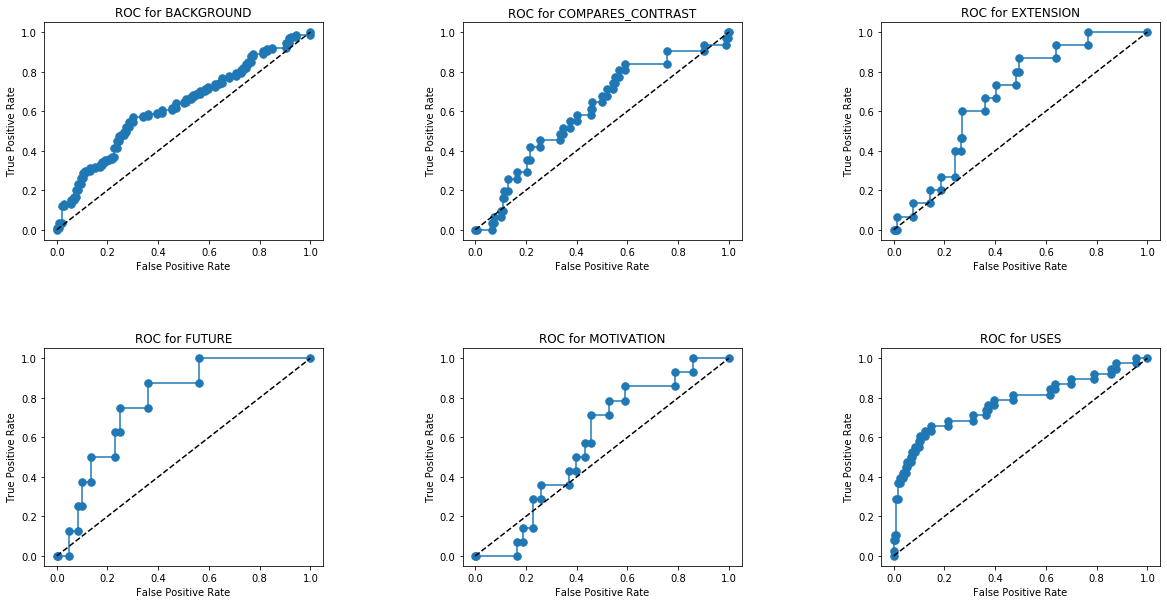

In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Binary problem

logreg = LogisticRegression(max_iter = 10000)
logreg.fit(trainX, df_train['citation_influence_label'])

probs = logreg.predict_proba(testX)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['citation_influence_label'], lr_probs)

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential using Logistic Regression")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1], [0,1], linestyle = '--', c = 'k')
plt.show()

# Multiclass problem
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    clf = LogisticRegression(max_iter = 10000)
    # Treat each as a one vs all classificaiton problem for each class
    trainy = (df_train["citation_class_label"] == i).astype(int).to_numpy()
    clf.fit(trainX, trainy)
    
    y_true = (df_test["citation_class_label"] == i).astype(int).to_numpy()
    probs = clf.predict_proba(testX)[:, 1]
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

In [340]:
# Accuracy + Macro F1

predy = logreg.predict(testX)
inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

logclf = LogisticRegression(max_iter = 10000)
logclf.fit(trainX, df_train['citation_class_label'])
predy = logclf.predict(testX)
class_acc = accuracy_score(df_test['citation_class_label'], predy)
class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

print("Influence Accuracy: {}\nClass Accuracy: {}\nClass Macro-F1: {}".format(inf_acc, class_acc, class_f1))

Influence Accuracy: 0.5497835497835498
Class Accuracy: 0.5497835497835498
Class Macro-F1: 0.1415683082349749


## XGBoost

C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


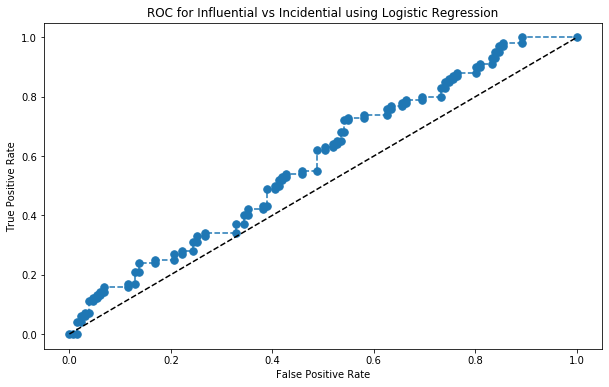

C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


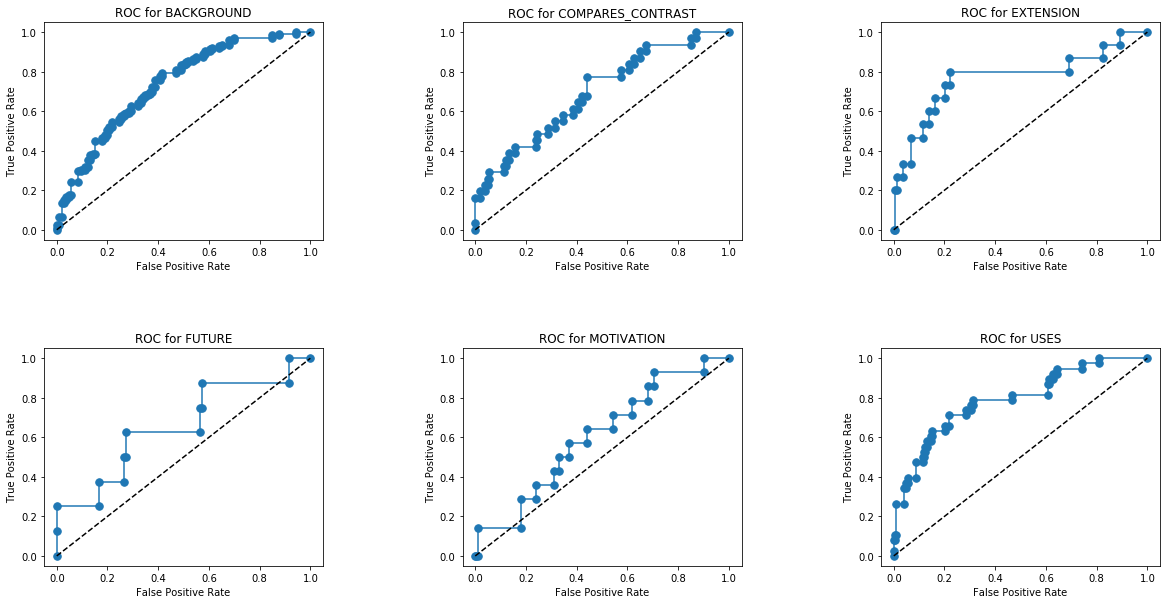

In [322]:
import xgboost as xgb

# Binary problem

xgbreg = xgb.XGBClassifier(n_estimators=100, max_depth=3)
xgbreg.fit(trainX, df_train['citation_influence_label'])

probs = xgbreg.predict_proba(testX)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['citation_influence_label'], lr_probs)

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential using XGBoost")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1], [0,1], linestyle = '--', c = 'k')
plt.show()

# Multiclass problem
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    clf = xgb.XGBClassifier(n_estimators=100, max_depth=3)
    # Treat each as a one vs all classificaiton problem for each class
    trainy = (df_train["citation_class_label"] == i).astype(int).to_numpy()
    clf.fit(trainX, trainy)
    
    y_true = (df_test["citation_class_label"] == i).astype(int).to_numpy()
    probs = clf.predict_proba(testX)[:, 1]
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

In [323]:
# Accuracy + Macro F1

predy = xgbreg.predict(testX)
inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

xgbclf = xgb.XGBClassifier(n_estimators=100, max_depth=3)
xgbclf.fit(trainX, df_train['citation_class_label'])
predy = xgbclf.predict(testX)
class_acc = accuracy_score(df_test['citation_class_label'], predy)
class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

print("Influence Accuracy: {}\nClass Accuracy: {}\nClass Macro-F1: {}".format(inf_acc, class_acc, class_f1))

C:\Users\binyu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Influence Accuracy: 0.5800865800865801
Class Accuracy: 0.6147186147186147
Class Macro-F1: 0.36265184661322397


### Random Forest

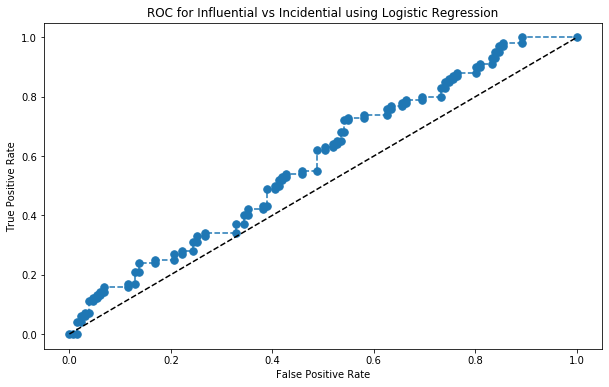

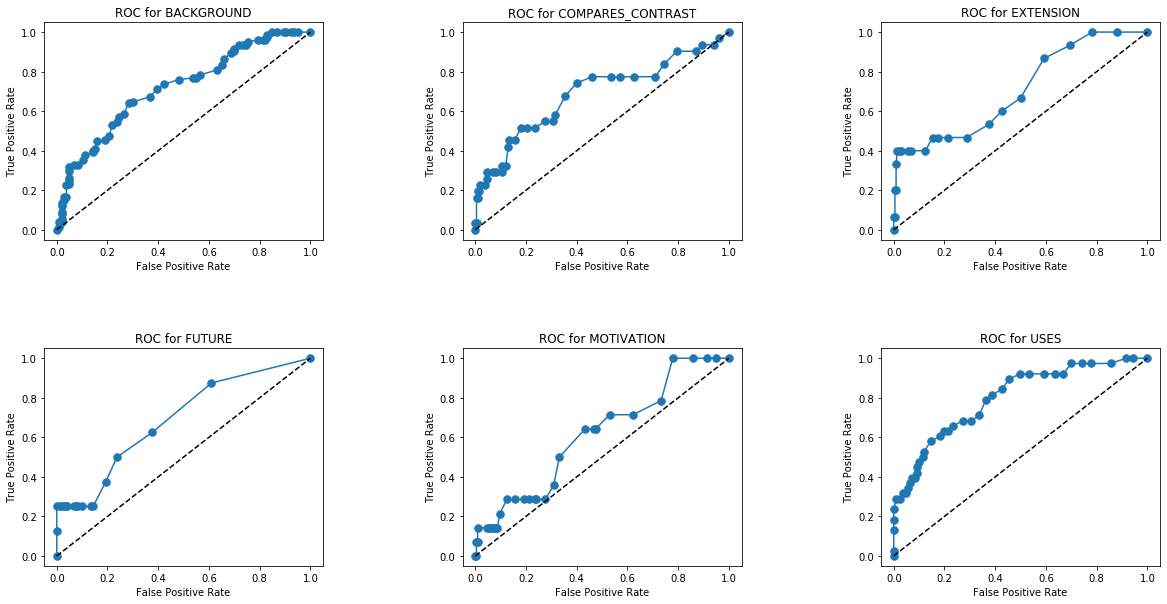

In [324]:
from sklearn.ensemble import RandomForestClassifier

# Binary problem

rfclf = RandomForestClassifier(n_estimators=100)
rfclf.fit(trainX, df_train['citation_influence_label'])

probs = rfclf.predict_proba(testX)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['citation_influence_label'], lr_probs)

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential using Random Forests")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1], [0,1], linestyle = '--', c = 'k')
plt.show()

# Multiclass problem
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    clf = RandomForestClassifier(n_estimators=100)
    # Treat each as a one vs all classificaiton problem for each class
    trainy = (df_train["citation_class_label"] == i).astype(int).to_numpy()
    clf.fit(trainX, trainy)
    
    y_true = (df_test["citation_class_label"] == i).astype(int).to_numpy()
    probs = clf.predict_proba(testX)[:, 1]
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

In [325]:
# Accuracy + Macro F1

predy = rfclf.predict(testX)
inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

rfclfm = RandomForestClassifier(n_estimators=100)
rfclfm.fit(trainX, df_train['citation_class_label'])
predy = rfclfm.predict(testX)
class_acc = accuracy_score(df_test['citation_class_label'], predy)
class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

print("Influence Accuracy: {}\nClass Accuracy: {}\nClass Macro-F1: {}".format(inf_acc, class_acc, class_f1))

Influence Accuracy: 0.5670995670995671
Class Accuracy: 0.6060606060606061
Class Macro-F1: 0.3647869674185464


# Finding most important features
(Using a RF model)

First, test importance of glove embeddings by training a RF model on purely handgenerated features

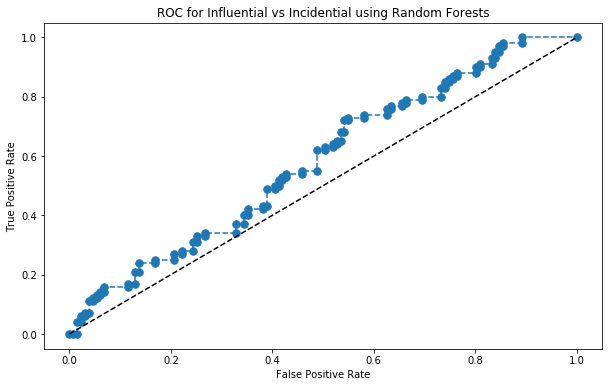

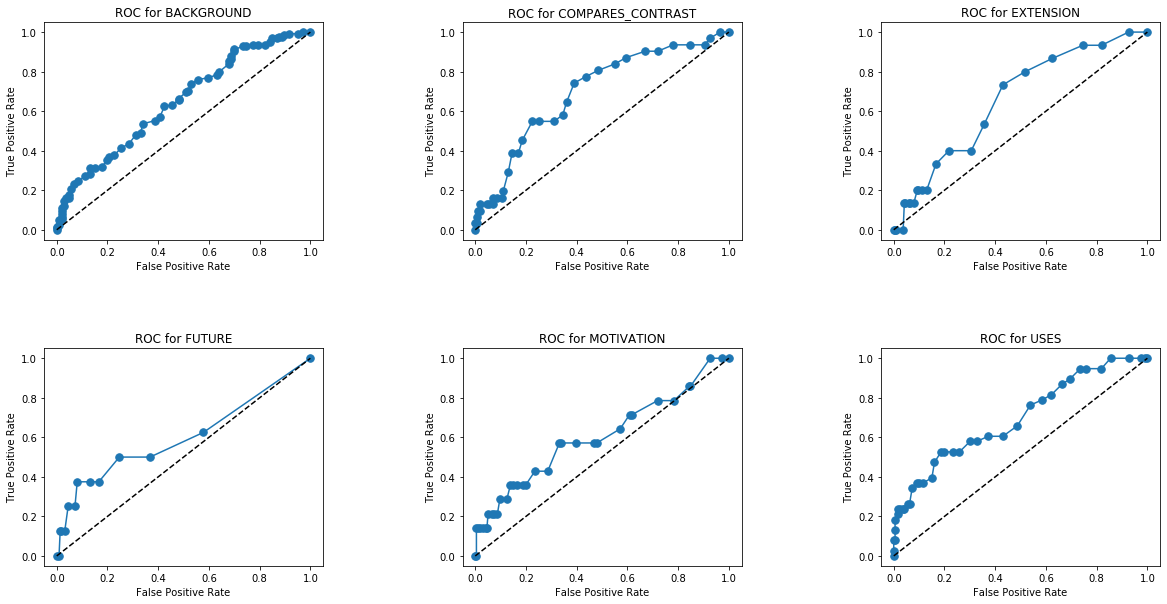

In [333]:
trainX_hand = trainX[:, :19]
testX_hand = testX[:, :19]

# Binary problem

rfclf_hand = RandomForestClassifier(n_estimators=100)
rfclf_hand.fit(trainX_hand, df_train['citation_influence_label'])

probs = rfclf_hand.predict_proba(testX_hand)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['citation_influence_label'], lr_probs)

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential using Random Forests")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1], [0,1], linestyle = '--', c = 'k')
plt.show()

# Multiclass problem
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    clf = RandomForestClassifier(n_estimators=100)
    # Treat each as a one vs all classificaiton problem for each class
    trainy = (df_train["citation_class_label"] == i).astype(int).to_numpy()
    clf.fit(trainX_hand, trainy)
    
    y_true = (df_test["citation_class_label"] == i).astype(int).to_numpy()
    probs = clf.predict_proba(testX_hand)[:, 1]
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

In [335]:
# Accuracy + Macro F1

predy = rfclf_hand.predict(testX_hand)
inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

rfclfm_hand = RandomForestClassifier(n_estimators=100)
rfclfm_hand.fit(trainX_hand, df_train['citation_class_label'])
predy = rfclfm_hand.predict(testX_hand)
class_acc = accuracy_score(df_test['citation_class_label'], predy)
class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

print("Influence Accuracy: {}\nClass Accuracy: {}\nClass Macro-F1: {}".format(inf_acc, class_acc, class_f1))

Influence Accuracy: 0.6277056277056277
Class Accuracy: 0.5714285714285714
Class Macro-F1: 0.22909917590224496


Aight so it looks like our hand generated features are kinda useless and we should just use the glove embeddings. Let's try to plug in just the glove embeddings and see what happens.

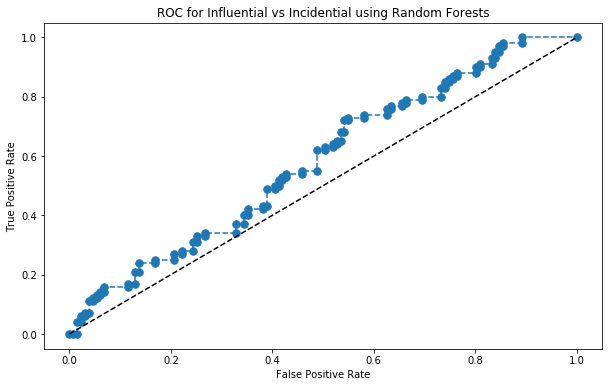

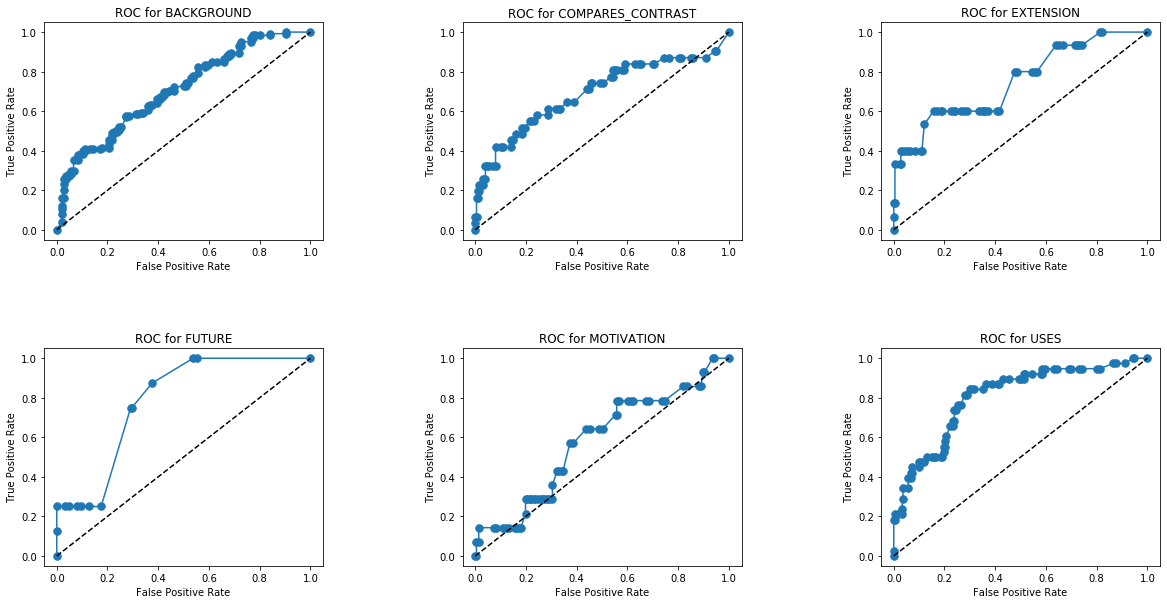

In [337]:
trainX_glove = trainX[:, 19:]
testX_glove = testX[:, 19:]

# Binary problem

rfclf_glove = RandomForestClassifier(n_estimators=100)
rfclf_glove.fit(trainX_glove, df_train['citation_influence_label'])

probs = rfclf_glove.predict_proba(testX_glove)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['citation_influence_label'], lr_probs)

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential using Random Forests")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.plot([0,1], [0,1], linestyle = '--', c = 'k')
plt.show()

# Multiclass problem
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    clf = RandomForestClassifier(n_estimators=100)
    # Treat each as a one vs all classificaiton problem for each class
    trainy = (df_train["citation_class_label"] == i).astype(int).to_numpy()
    clf.fit(trainX_glove, trainy)
    
    y_true = (df_test["citation_class_label"] == i).astype(int).to_numpy()
    probs = clf.predict_proba(testX_glove)[:, 1]
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

In [338]:
# Accuracy + Macro F1

predy = rfclf_glove.predict(testX_glove)
inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

rfclfm_glove = RandomForestClassifier(n_estimators=100)
rfclfm_glove.fit(trainX_glove, df_train['citation_class_label'])
predy = rfclfm_glove.predict(testX_glove)
class_acc = accuracy_score(df_test['citation_class_label'], predy)
class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

print("Influence Accuracy: {}\nClass Accuracy: {}\nClass Macro-F1: {}".format(inf_acc, class_acc, class_f1))

Influence Accuracy: 0.6103896103896104
Class Accuracy: 0.6017316017316018
Class Macro-F1: 0.36424868812545325


Seems very similar to the original macro-F1 / accuracy ... very depressing

Just to make sure, for each of the handgenerated features, we can scramble them in the test data and to see if there's any difference.

In [341]:
for i in range(19):
    testX_scramble = testX[:, :]
    np.random.shuffle(testX_scramble[:,i])
    
    # Use original model
    predy = rfclf.predict(testX_scramble)
    inf_acc = accuracy_score(df_test['citation_influence_label'], predy)

    predy = rfclfm.predict(testX_scramble)
    class_acc = accuracy_score(df_test['citation_class_label'], predy)
    class_f1 = f1_score(df_test['citation_class_label'], predy, average = 'macro')

    print("Scrambling feature {}:\n\tInfluence Accuracy: {}\n\tClass Accuracy: {}\n\tClass Macro-F1: {}".format(i,inf_acc, class_acc, class_f1))

Scrambling feature 0:
	Influence Accuracy: 0.5714285714285714
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 1:
	Influence Accuracy: 0.5800865800865801
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 2:
	Influence Accuracy: 0.5757575757575758
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 3:
	Influence Accuracy: 0.5714285714285714
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 4:
	Influence Accuracy: 0.5670995670995671
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 5:
	Influence Accuracy: 0.5844155844155844
	Class Accuracy: 0.6017316017316018
	Class Macro-F1: 0.3633066116828714
Scrambling feature 6:
	Influence Accuracy: 0.5887445887445888
	Class Accuracy: 0.6060606060606061
	Class Macro-F1: 0.3647869674185464
Scrambling feature 7:
	Influence Accuracy: 0.5714285714285714


# Learning curves for RF

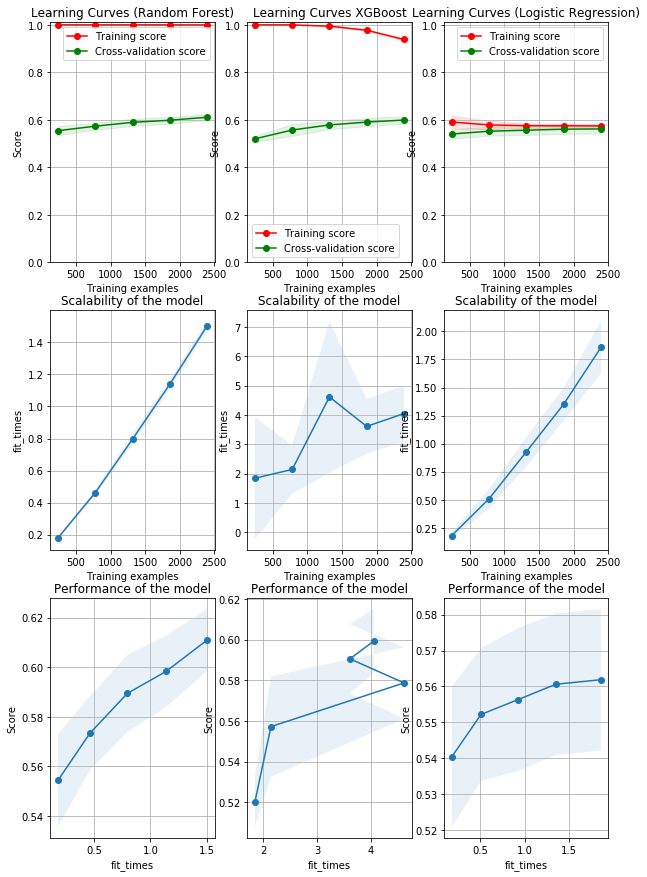

In [396]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(10, 15))

X, y = np.array([*df['embedding']]), df['citation_class_label']

title = "Learning Curves (Random Forest)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(n_estimators=100)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.0, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves XGBoost"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgb.XGBClassifier(n_estimators=100, max_depth=3)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.0, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (Logistic Regression)"
# Logistic Regression is less expensive so we do a higher number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(max_iter = 10000)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.0, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

# Trying the RF Model on SDP Test Data

## Create Embeddings for SDP Test

In [ ]:
sdp_test = pd.read_csv("SDP_test.csv")
sdp_test_temp = sdp_test.copy()

In [355]:
# Create a new column in the dataframe to store the overlap feature
sdp_test_temp["keyword_overlap"] = np.zeros(sdp_test_temp.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in sdp_test_temp.index:
    # Grab the citing and cited title
    citing_title = sdp_test_temp.loc[row]["citing_title"]
    cited_title = sdp_test_temp.loc[row]["cited_title"]
    
    # Compute the filtered versions of both
    citing_words = drop_stop_words(citing_title)
    cited_words = drop_stop_words(cited_title)
    
    # Count the overlap
    overlap = len(set(citing_words) & set(cited_words)) 
    sdp_test_temp.at[row,"keyword_overlap"] = overlap

In [356]:
# Create a new column in the dataframe to store the num verbs feature
sdp_test_temp["num_verbs"] = np.zeros(sdp_test_temp.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in sdp_test_temp.index:
    # Grab the citation context
    context = sdp_test_temp.loc[row]["citation_context"]
    
    # Compute the verb count
    verb_count = count_verbs(context)
    
    # Count the overlap
    sdp_test_temp.at[row,"num_verbs"] = verb_count

In [357]:
tenses = ["VB","VBZ", "VBG", "VBN", "VBD"]
for tense in tenses:
    # Create feature
    feature_name = f"num_verbs_{tense}"
    sdp_test_temp[feature_name] = np.zeros(sdp_test_temp.shape[0])

    # Traverse through all the rows of the dataframe and generate the new feature
    for row in sdp_test_temp.index:
        # Grab the citation context
        context = sdp_test_temp.loc[row]["citation_context"]

        # Compute the verb count
        verb_count = count_verbs_tense(context, tense)

        # Count the overlap
        sdp_test_temp.at[row,feature_name] = verb_count

In [359]:
sdp_test_temp['citation_rel_loc'] = (sdp_test_temp['citation_context'].str.index("#AUTHOR_TAG")) / (sdp_test_temp['citation_context'].str.len() - 11)

In [360]:
citation_rel_punc = []
for i in sdp_test_temp.index:
    text = sdp_test_temp['citation_context'].loc[i]
    ind = text.index('#AUTHOR_TAG')
    val = -1
    start = 0
    end = len(text) - 1
    for j in range(ind, 0, -1):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            start = j
            break
    for j in range(ind, len(text)):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            end = j
            break
    end -= 10
    val = (ind - start) / (end - start)
    citation_rel_punc.append(val)

sdp_test_temp['citation_rel_punc'] = citation_rel_punc

In [361]:
sdp_test_temp['citation_len'] = sdp_test_temp['citation_context'].str.split().str.len() - 1 # -1 for #AUTHOR_TAG

In [362]:
sdp_test_temp['num_citations'] = sdp_test_temp['citation_context'].str.count('\[') - sdp_test_temp['citation_context'].str.count('\[#AUTHOR_TAG\]')

In [363]:
citation_in_paren = []
for i in range(len(sdp_test_temp)):
    text = sdp_test_temp['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ')':
            for k in range(j, 0, -1):
                if text[k] == '(':
                    if ind > k and ind < j:
                        flag = 1
    citation_in_paren.append(flag)

sdp_test_temp['citation_in_paren'] = citation_in_paren

In [364]:
active_verb = []
for i in range(len(sdp_test_temp)):
    text = nltk.word_tokenize(df['citation_context'].iloc[i])
    pos_tagged = nltk.pos_tag(text)
    for s in [y[0] for y in pos_tagged]:
        if 'AUTHOR_TAG' in s:
            index = [y[0] for y in pos_tagged].index(s)
            break
    if index != len(pos_tagged) - 1 and 'VB' in pos_tagged[index + 1][1]:
        active_verb.append(1)
    else:
        active_verb.append(0)
        
sdp_test_temp['active_verb'] = active_verb

In [365]:
desc = []
for i in range(len(sdp_test_temp)):
    text = sdp_test_temp['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ',':
            if j + 2 < len(text) and text[j + 2] == 'a':
                flag = 1
            break
    desc.append(flag)

sdp_test_temp['citation_description'] = desc

In [366]:
sent_pat_feature = sdp_test_temp['citation_context'].apply(get_custom_pattern_features_wrapper)

In [367]:
types = ['Background', 'CompareOrContrast', 'Prior', 'Future', 'Motivation', 'Uses']

for i in range(len(types)):
    # Convert each feature into a number (count the cases)
    score = sent_pat_feature.apply(countCases, args=(types[i], ))
    feature_name = f"sentence_pattern_{types[i]}"
    sdp_test_temp[feature_name] = score

In [368]:
sdp_test_temp["tokens"] = [word_tokenize(context.replace("#AUTHOR_TAG", "")) for context in sdp_test_temp["citation_context"]]

threshold = 3 #frequency threshold for throwing out words

tokenized_corpus = []
[tokenized_corpus.extend(word_tokenize(context.replace("#AUTHOR_TAG", ""))) for context in sdp_test_temp["citation_context"]]
fdist = nltk.FreqDist(tokenized_corpus)
fdftotal = pd.DataFrame(fdist.items(), columns = ['word', 'freq'])
fdf = fdftotal.loc[fdftotal.freq > threshold]

In [369]:
glovepath = "./glove.6B"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [374]:
X1 = np.array([embed_context(tokens, fdf) for tokens in sdp_test_temp["tokens"]])

temp1 = []
for i in range(len(X1)):
    t = tuple(X1[i])
    temp1.append(t)

In [381]:
sdp_test_temp['embedding'] = list(zip(sdp_test_temp.keyword_overlap, sdp_test_temp.num_verbs, sdp_test_temp.num_verbs_VB,
                                      sdp_test_temp.num_verbs_VBD, sdp_test_temp.num_verbs_VBN, sdp_test_temp.num_verbs_VBG, 
                                      sdp_test_temp.num_verbs_VBZ, sdp_test_temp.citation_rel_loc, 
                                      sdp_test_temp.citation_rel_punc,sdp_test_temp.citation_len, sdp_test_temp.num_citations, 
                                      sdp_test_temp.citation_in_paren, sdp_test_temp.active_verb, 
                                      sdp_test_temp.citation_description, sdp_test_temp.sentence_pattern_Background, 
                                      sdp_test_temp.sentence_pattern_CompareOrContrast, np.zeros(len(sdp_test_temp)),
                                      sdp_test_temp.sentence_pattern_Uses, sdp_test_temp.sentence_pattern_Prior))
#  df.sentence_pattern_Future are all array of 0's.
embed1 = []
for i in range(len(sdp_test_temp)):
    t = sdp_test_temp['embedding'].iloc[i] + temp1[i]
    embed1.append(t)
    
# Normalize features
temp2 = pd.DataFrame(np.array(embed1))
for c in temp2.columns:
    if c == 16:
        continue
    if temp2[c].max() == temp2[c].min():
        print(c)
    temp2[c] = (temp2[c] - temp2[c].min()) / (temp2[c].max() - temp2[c].min())

e2 = list(map(tuple, np.array(temp2)))

sdp_test_temp['embedding'] = e2

## Predict using trained RF model

In [382]:
sdp_testX = np.array([*sdp_test_temp['embedding']])
predy = rfclfm.predict(sdp_testX)
sdp_test['citation_class_label'] = predy

## Convert to csv

In [386]:
sdp_pred = sdp_test[['unique_id', 'citation_class_label']]

In [387]:
sdp_pred.to_csv('sdp_test_predictions.csv', index=False)

Macro-F1 score: 0.14103

In [388]:
sdp_test['citation_influence_label'] = rfclf.predict(sdp_testX)

In [389]:
sdp_pred_inf = sdp_test[['unique_id', 'citation_influence_label']]
sdp_pred_inf.to_csv('sdp_test_inf.csv', index = False)

## Trying Neural Networks

In [68]:
from torch import nn

input_dim = len(df['embedding'].iloc[0])

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(input_dim, 64)
        # Output layer, 2
        self.output = nn.Linear(64, 2)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)